<a href="https://colab.research.google.com/github/camoalon/language_genes/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genes and Phonemes
In this code, we reproduce some of the results from [Creanza et al.](https://www.pnas.org/content/112/5/1265). Once reproducibility is verified, a subset of the data is used to compare the analysis method used in [Creanza et al.](https://www.pnas.org/content/112/5/1265) (PCA+Procrustes) versus the method presented in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841) (PCCA).

# Import packages and data

## Import packages

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns

## Define Procrustes
The Procrustes transformation implemented as [scipy.spatial.procrustes](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.spatial.procrustes.html) did not seem to provide a correct result, so we decided to use the Matlab implementation of Procrustes translated to Python syntax (see [here](https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy) for details). Hence, it is necessary to define the procrustes function below.

In [0]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

## Import data from Github

The data is stored on a private Github repository. We first clone the repositoy into the server and then read the .txt files to appropriately save the relevant data into variables.

###Load the data into the server

In [81]:
! git clone https://github.com/camoalon/language_genes.git

Cloning into 'language_genes'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 73 (delta 18), reused 21 (delta 4), pack-reused 0
Unpacking objects: 100% (73/73), done.


###Read the data of the PNAS paper
These are the supplementary data published together with [Creanza et al.](https://www.pnas.org/content/112/5/1265). They are only the data corresponding with the phonemes in the Ruhlen database as no data about the PHOIBLE or the alleles could be found as suplementary material of the paper. 

In [82]:
% cd language_genes/data/PNAS

/content/language_genes/data/language_genes/data/language_genes/data/PNAS


In [0]:
paper = pd.read_csv('pnas.1424033112.sd01.txt', skiprows = 17, sep = "\t", header = None)

coordinates_paper = paper.iloc[:,7:9]
phonemes_paper = paper.iloc[:,9:737]
continents_paper = paper[6]

###Read the data from Nicole's email

These are the data that Lior sent to me in a forwaded email. I assume these are just a subset of the actual data in the paper. 

In [84]:
% cd ..

/content/language_genes/data/language_genes/data/language_genes/data


In [0]:
phonemes = pd.read_csv('Phonemes139forShannon.txt',sep='\t',header=None)
phonemes.drop(139,axis=1,inplace=True)

alleles = pd.read_csv('AlleleFrequencies_139forShannon.txt',sep='\t',header=None)
alleles.drop(139,axis=1,inplace=True)

coordinates = pd.read_csv('LongLat_Unscaled_139forShannon.txt',sep='\t',header=None)
coordinates.drop(139,axis=1,inplace=True)

languages = pd.read_csv('Names_139forShannon.txt',sep='\t')

Since in these data we do not have the continent for each set of phonemes/alleles but we do have the language name, we can extract the corresponding continents by reading the data provided in the supplementary material of the paper. 

In [0]:
languages_names = np.array(languages["Language name"])

continents = np.empty(len(languages_names),dtype="U25")

for index,elements in enumerate(languages_names):
  lang = elements[:-1]
  continents[index] = paper.loc[paper[1] == lang][6].values[0]

# Replicate data from PNAS paper
We start by replicating the analysis that led to Figure 1 (B) in [Creanza et al.](https://www.pnas.org/content/112/5/1265) to verify that the steps followed in this script are consistent with the paper. Only data from the Ruhlen database were provided, but this is enough to verify that the analysis done in this script matches the one in the paper. 

### Perform PCA on the Ruhlen database

In [0]:
pca = PCA()
pca.fit(phonemes_paper)
pca_data = pca.transform(phonemes_paper)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_paper_pca = pd.DataFrame(pca_data, columns=labels)

phonemes_paper_pc = pd.DataFrame([phonemes_paper_pca.PC1, phonemes_paper_pca.PC2]).T

Plot the two first principal components:

Text(0, 0.5, 'PC2 - 7.1%')

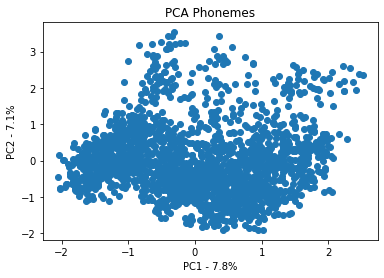

In [88]:
plt.scatter(phonemes_paper_pc['PC1'], phonemes_paper_pc['PC2'])
plt.title('PCA Phonemes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

This result matches exactly (PC1 $7.8$%, PC2 $7.1$%) the result in Fig. S1 (A) in the supplementary material of [Creanza et al.](https://www.pnas.org/content/112/5/1265)

###Perform Procrustres analysis on the first two Principal Components

In [0]:
d_paper, Z_paper, t_paper = procrustes(coordinates_paper.values, phonemes_paper_pc.values)

Plot the result of the procurstes analysis on the two principal components:

0.3662383058032033


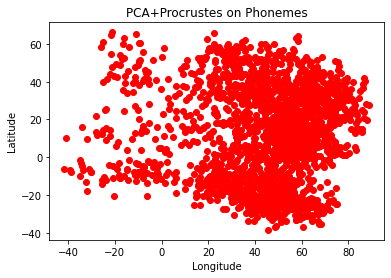

In [90]:
plt.scatter(Z_paper.T[1], Z_paper.T[0], c = "r")
plt.title('PCA+Procrustes on Phonemes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
t0 = np.sqrt(1-d_paper)
print(t0)

This result does not quite match the result from Fig. 1 (A) in [Creanza et al.](https://www.pnas.org/content/112/5/1265), where the similarity statistic $t_0$ was reported to be $0.57$. In our case the similarity statistic was about $0.37$ (reported above). However, the range in the x-axis does not match the one in Fig. 1 (A) either. This suggests that the coordinates reported in the supplementary data and the ones used in the analysis for the paper differ by some constant (as is also suggested by Nicole's email on the scaled vs unscaled coordinates). This slight modification can be the cause of discrepancy observed in the value of the similarity statistic. For this reason, we proceed our analysis.

###Label the data with the corresponding continent

0.3662383058032033


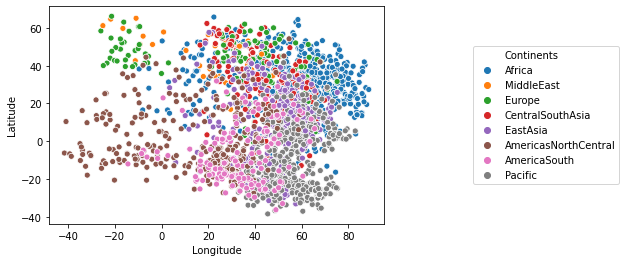

In [91]:
result_paper = pd.DataFrame(Z_paper)
result_paper['Continents'] = continents_paper
result_paper.columns = ['Latitude','Longitude','Continents']

g = sns.scatterplot(result_paper['Longitude'], result_paper['Latitude'],hue = result_paper['Continents'], legend = "brief")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

t0 = np.sqrt(1-d_paper)
print(t0)

This plot is identical to the previous one with the only difference that now the color for each of the points correspond to the continent where the language is spoken,

###Cluster the data according to the continent
We proceed as in [Creanza et al.](https://www.pnas.org/content/112/5/1265), where the data resulting from the previous figure are lumped into clusters and represented with circles centered at the coordinate mean of the coordinates fo the languages in the continent and with size proportional to the number of languages in the continent.

In [0]:
labels_continents_paper = list(result_paper['Continents'].unique())
latitude_paper = np.empty(len(labels_continents_paper))
longitude_paper = np.empty(len(labels_continents_paper))
size_paper = np.empty(len(labels_continents_paper))

for i,elements in enumerate(labels_continents_paper): 
  tmp = result_paper.loc[result_paper['Continents'] == elements]
  latitude_paper[i] = np.mean(tmp["Latitude"])
  longitude_paper[i] = np.mean(tmp["Longitude"])
  size_paper[i] = len(tmp["Latitude"])

cluster_paper = pd.DataFrame([latitude_paper,longitude_paper,size_paper,labels_continents_paper]).T
cluster_paper.columns = ['Latitude','Longitude','Size','Continent']

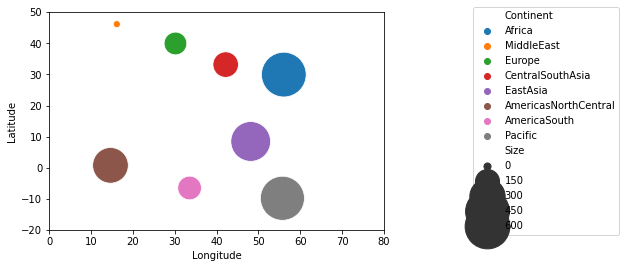

In [93]:
g = sns.scatterplot(cluster_paper['Longitude'],cluster_paper['Latitude'],size=cluster_paper['Size'],hue=cluster_paper['Continent'],sizes=(50,2000))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(0, 80)
xaxis = plt.ylim(-20, 50)

This figure is very much the same as Fig. 1 (A) in [Creanza et al.](https://www.pnas.org/content/112/5/1265), with the difference that this plot is somehow translated and rotated with respect to the original Fig. 1 (A). Again, we think this is a consequence of the scaling of the coordinates and as such it seems that the results for the Ruhlen databse in [Creanza et al.](https://www.pnas.org/content/112/5/1265) can be reproduced in this script.



# Compare PCA+Procrustes with PCCA
In this section we use a reduced version of the data (obtained from Nicole's email). This time we have phoneme information as well as allele information. We perform two different analysis of the data:
1.   The same analysis as the one presented in [Creanza et al.](https://www.pnas.org/content/112/5/1265), which was just reproduced in the previous section. To do this we do PCA+Procrustes of both the phonemes and the alleles, and then compare both plots of the prinicipal components since they have been expressed in the coordinates framework thanks to the Procrustes analysis.
2.   A PCCA analysis as described in [Brown et al.](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841), where we use allele information to find the projection for the phoneme data. No coordinate information is needed for this analysis since alleles and phonemes information can be combined directly in a single plot. 

##PCA+Procrustes
We perform the analysis following the approach in [Creanza et al.](https://www.pnas.org/content/112/5/1265), identical to the one in the previous subsection.

### On the Alleles

We perform PCA and we plot the first two components as in the previous section.

In [0]:
pca = PCA()
pca.fit(alleles.T)
pca_alleles = pca.transform(alleles.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

alleles_pca = pd.DataFrame(pca_alleles, columns=labels)

alleles_pc = pd.DataFrame([alleles_pca.PC1, alleles_pca.PC2]).T

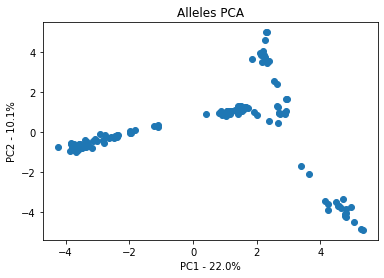

In [95]:
plt.scatter(alleles_pc['PC1'], alleles_pc['PC2'])
plt.title('Alleles PCA')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We perform Procrustes on the PC and we plot it as in the previous section.

In [0]:
d_alleles, Z_alleles, t_alleles = procrustes(coordinates.T.values, alleles_pc.values)

0.4979753699793969


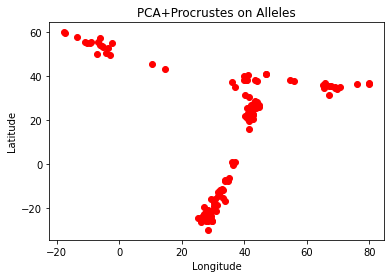

In [97]:
plt.scatter(Z_alleles.T[0], Z_alleles.T[1], c = "r")
plt.title('PCA+Procrustes on Alleles')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

t0 = np.sqrt(1-d_alleles)
print(t0)

We label the data with the corresponding contient for each of the points above, just like in the previous section. 

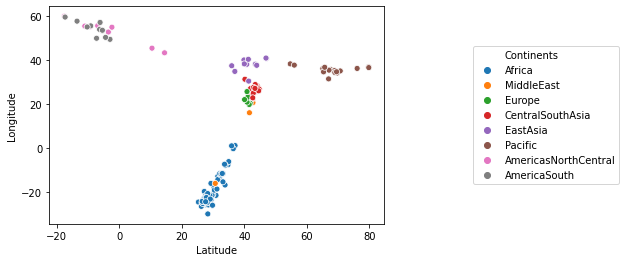

In [98]:
result_alleles = pd.DataFrame(Z_alleles)
result_alleles['Continents'] = continents
result_alleles.columns = ['Latitude','Longitude','Continents']

g = sns.scatterplot(result_alleles['Latitude'], result_alleles['Longitude'], hue = result_alleles['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)


We lump the data by continent in the exact same way as done in the previous section.

In [0]:
latitude_alleles = np.empty(len(continents))
longitude_alleles = np.empty(len(continents))
size_alleles = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_alleles.loc[result_alleles['Continents'] == elements]
  latitude_alleles[i] = np.mean(tmp["Latitude"])
  longitude_alleles[i] = np.mean(tmp["Longitude"])
  size_alleles[i] = len(tmp["Latitude"])

cluster_alleles = pd.DataFrame([latitude_alleles,longitude_alleles,size_alleles,continents]).T
cluster_alleles.columns = ['Latitude','Longitude','Size','Continent']

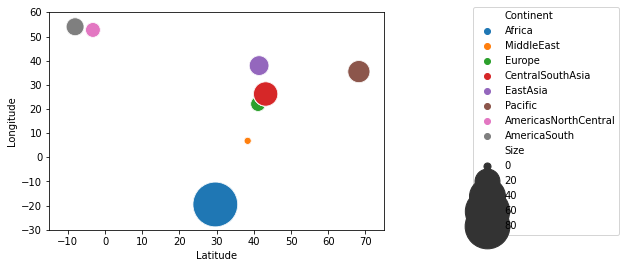

In [100]:
g = sns.scatterplot(cluster_alleles['Latitude'],cluster_alleles['Longitude'],size=cluster_alleles['Size'],hue=cluster_alleles['Continent'],sizes=(50,2000))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(-15,75)
xaxis = plt.ylim(-30,60)

###On the Phonemes

We perform PCA and we plot the first two components as in the previous section.

In [0]:
pca = PCA()
pca.fit(phonemes.T)
pca_phonemes = pca.transform(phonemes.T)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

phonemes_pca = pd.DataFrame(pca_phonemes, columns=labels)

phonemes_pc = pd.DataFrame([phonemes_pca.PC1, phonemes_pca.PC2]).T

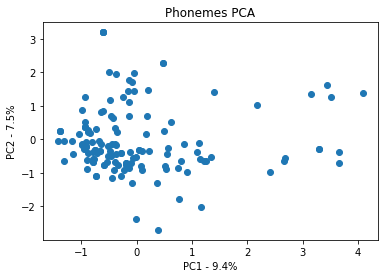

In [102]:
plt.scatter(phonemes_pc['PC1'], phonemes_pc['PC2'])
plt.title('Phonemes PCA')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We perform Procrustes on the PC and we plot it as in the previous section.

In [0]:
d_phonemes, Z_phonemes, t_phonemes = procrustes(coordinates.T.values, phonemes_pc.values)

0.16257693491744693


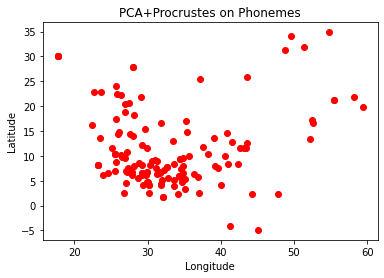

In [104]:
plt.scatter(Z_phonemes.T[0], Z_phonemes.T[1], c = "r")
plt.title('PCA+Procrustes on Phonemes')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
t0 = np.sqrt(1-d_phonemes)
print(t0)

We label the data with the corresponding contient for each of the points above, just like in the previous section. 

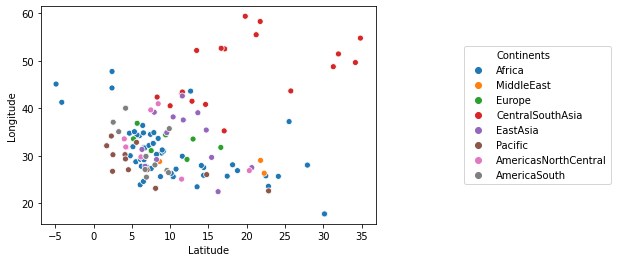

In [105]:
result_phonemes = pd.DataFrame(Z_phonemes)
result_phonemes['Continents'] = continents
result_phonemes.columns = ['Longitude','Latitude','Continents']

g = sns.scatterplot(result_phonemes['Latitude'],result_phonemes['Longitude'],hue = result_phonemes['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

We lump the data by continent in the exact same way as done in the previous section.

In [0]:
latitude_phonemes = np.empty(len(continents))
longitude_phonemes = np.empty(len(continents))
size_phonemes = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_phonemes.loc[result_phonemes['Continents'] == elements]
  latitude_phonemes[i] = np.mean(tmp["Latitude"])
  longitude_phonemes[i] = np.mean(tmp["Longitude"])
  size_phonemes[i] = len(tmp["Latitude"])

cluster_phonemes = pd.DataFrame([latitude_phonemes,longitude_phonemes,size_phonemes,continents]).T
cluster_phonemes.columns = ['Latitude','Longitude','Size','Continent']

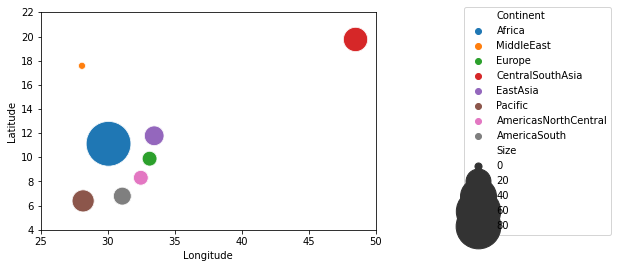

In [107]:
g = sns.scatterplot(cluster_phonemes['Longitude'],cluster_phonemes['Latitude'],size=cluster_phonemes['Size'],hue=cluster_phonemes['Continent'],sizes=(50,2000))

g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
yaxis = plt.xlim(25,50)
xaxis = plt.ylim(4,22)

## PCCA
We perform the analysis described in [Brown et al](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007841). In particular, we use allele information to find the projection for the phoneme data. The first two components of the projection are plotted below. 

In [0]:
n_components = 2;
cca = CCA(n_components)
cca.fit(alleles_pca,phonemes_pca)
CCA(n_components)
X, Y = cca.transform(alleles_pca,phonemes_pca)

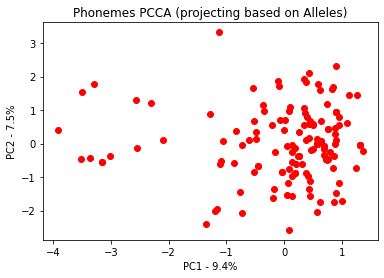

In [109]:
plot = plt.scatter(Y.T[0], Y.T[1], c = "r")
plt.title('Phonemes PCCA (projecting based on Alleles)')
xlabel = plt.xlabel('PC1 - {0}%'.format(per_var[0]))
ylabel = plt.ylabel('PC2 - {0}%'.format(per_var[1]))

We label the data with the corresponding contient for each of the points above, just like in the previous section. 

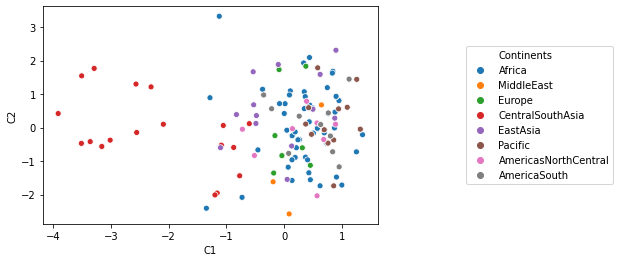

In [110]:
result_cca = pd.DataFrame(Y)
result_cca['Continents'] = continents
result_cca.columns = ['C1','C2','Continents']

g = sns.scatterplot(result_cca['C1'], result_cca['C2'], hue = result_alleles['Continents'], legend = "brief")
legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

We lump the data in the exact same way as in the previous analysis for the sake of a simpler comparison.

In [0]:
latitude_cca = np.empty(len(continents))
longitude_cca = np.empty(len(continents))
size_cca = np.empty(len(continents))

for i,elements in enumerate(continents): 
  tmp = result_cca.loc[result_cca['Continents'] == elements]
  latitude_cca[i] = np.mean(tmp["C1"])
  longitude_cca[i] = np.mean(tmp["C2"])
  size_cca[i] = len(tmp["C1"])

cluster_cca = pd.DataFrame([latitude_cca,longitude_cca,size_cca,continents]).T
cluster_cca.columns = ['C1','C2','Size','Continent']

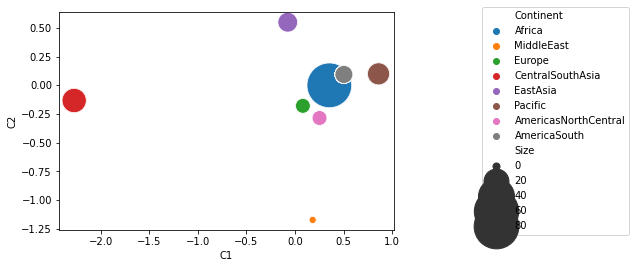

In [112]:
g = sns.scatterplot(cluster_cca['C1'],cluster_cca['C2'],size=cluster_cca['Size'],hue=cluster_cca['Continent'],sizes=(50,2000))

legend = g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)